This notebook is written to work with EKF and UKF for an example non-linear system.

Author: Süleyman Fatih Kara

# CV Model:

The CV model is provided by

$$\textbf{x}_k = \left[\begin{matrix} 1 \quad 0 \quad T_s \quad 0 \\ 0 \quad 1 \quad 0 \quad T_s \\
0 \quad 0 \quad 1 \quad 0 \\
0 \quad 0 \quad 0 \quad 1 \end{matrix}\right] \textbf{x}_{k-1} + v_{k-1},$$

where the state is defined as $\textbf{x}_k = \left[\begin{matrix}x_k \quad y_k \quad v_x \quad v_y\end{matrix}\right]^T.$

The process noise is a zero mean Gaussian random variable, $v_k \sim N(0,Q)$, whose covariance is equal to 

$$Q = \left[\begin{matrix} \frac{T_s^3}{3} \quad 0 \quad \frac{T_s^2}{2} \quad 0 \\ 0 \quad \frac{T_s^3}{3} \quad 0 \quad \frac{T_s^2}{2} \\
\frac{T_s^2}{2} \quad 0 \quad T_s \quad 0 \\
0 \quad \frac{T_s^2}{2} \quad 0 \quad T_s \end{matrix}\right].$$

The sonar provides measurements in polar coordinates as range and angle data, $y_k = [r_k \ \ \theta_{k}]^T$. One can provide the measurement update equation as below,
$$ y_k = h(\textbf{x}_k) + w_k,$$ 

where measurement noise is $w_k \sim N(0,R)$ with covariance matrix

$$R = \left[\begin{matrix} \sigma^2_r \quad 0\\ 0 \quad \sigma_{\theta}^2 \end{matrix}\right].$$

The equation above can be written explicitely as follows

$$\left[\begin{matrix} r_k \\ \theta_k \end{matrix} \right] = \left[\begin{matrix} \sqrt{x_k^2 + y_k^2} \\ tan^{-1}(\frac{y}{x}) \end{matrix} \right] + w_k.$$

Since the measurement update equations are nonlinear, we need the Jacobian matrix to linearize 

$$ H_k = \left[\begin{matrix} \frac{\partial r}{\partial x} \quad \frac{\partial r}{\partial y} \quad \frac{\partial r}{\partial v_x} \quad \frac{\partial r}{\partial v_y} \\ \frac{\partial \theta}{\partial x} \quad \frac{\partial \theta}{\partial y} \quad \frac{\partial \theta}{\partial v_x} \quad \frac{\partial \theta}{\partial v_y} \end{matrix} \right] = \left[\begin{matrix} \frac{x}{\sqrt{x^2+y^2}} \quad \frac{y}{\sqrt{x^2+y^2}} \quad 0 \quad 0 \\ \frac{-y}{x^2+y^2} \quad \frac{x}{x^2+y^2} \quad 0 \quad 0 \end{matrix}\right].$$

Extended kalman filter's time and measurement update equations are given as below. 

## EKF Time Update:
$$
\begin{align}
\textbf{x}_{k|k-1} &= F\textbf{x}_{k-1} \\
P_{k|k-1} &= FP_{k-1}F^T + Q
\end{align}
$$

## EKF Measurement Update:
$$
\begin{align}
\textbf{x}_{k} &= \textbf{x}_{k|k-1} + K_k(y_k - h(\textbf{x}_{k|k-1})) \\
P_{k} &= (I - K_kH_k)P_{k|k-1} \\
K_k &= P_{k|k-1}H_k^T(H_k P_{k|k-1} H_k^T + R)^ {-1}
\end{align}
$$
where $H_k$ is the Jacobian matrix of the function $h(.)$.



In [1]:
# Includes
import numpy as np
from numpy.linalg import inv
import scipy.io
import scipy.linalg as lin
import matplotlib.pyplot as plt
 

In [2]:
# Read the mat file and extract the true trajectory
mat = scipy.io.loadmat('simulated_trajectory.mat')
true_traj = mat['xTrue'] 

# Common Inits
Tfinal = 500  #total time step count
ny = 2        #dimension of measurements
nx = 4        #dimension of states
dt = 0.1      #sampling time in sec
sigma_r = 0.1 #starndard deviation of range measurement 0.1 m
sigma_t = 3   #starndard deviation of azimuth measurement 3 degrees
time = np.arange(0,50,dt)

# System matrices
F = np.matrix([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])
Q = np.matrix([[dt**3/3,0,dt**2/2,0],[0, dt**3/3,0,dt**2/2],[dt**2/2,0,dt,0],[0,dt**2/2,0,dt]])
R = np.matrix([[sigma_r**2,0],[0,sigma_t**2]])

# Function definition for measurement update equation
def h(x):
    rv = np.zeros((2,1))
    rv[0] = np.sqrt(x[0]**2 + x[1]**2)
    rv[1] = (np.arctan(x[1]/x[0]))*180/np.pi #should be in degree
    return rv

# Function definiton for generating N different random measurement sequences with length 500
def GenerateRandMeas():
    y_rand = np.zeros((ny,Tfinal))
    for tt in range(Tfinal):
        y_rand[:,[tt]] = h(true_traj[:,[tt]]) + np.random.multivariate_normal(np.zeros(ny), R, 1).T
            
    return y_rand
 

# EKF Implementation:

In [3]:
# Function definition to calculate the Jacobian matrix of h(.) at point x_k|k-1
def Hjacob(x):
    H = np.zeros((2,4))
    H[0,0] = x[0]/np.sqrt(x[0]**2 + x[1]**2)
    H[0,1] = x[1]/np.sqrt(x[0]**2 + x[1]**2)
    H[0,2] = 0
    H[0,3] = 0
    H[1,0] = (-x[1]/(x[0]**2 + x[1]**2))*180/np.pi
    H[1,1] = (x[0]/(x[0]**2 + x[1]**2))*180/np.pi
    H[1,2] = 0
    H[1,3] = 0
    return H

# Fuction definition for extended Kalman filter which takes input as measurement sequence and process noise scalar q 
def EKF(yin):
    x  = np.zeros((nx,Tfinal+1))
    x0 = np.matrix([true_traj[0,0], true_traj[1,0], 0, 0])
    x[:,0] = x0   
    P = np.diag([1,1,1,1])
    xx = np.zeros((nx,1))
    PP = np.zeros((nx,nx))
    yx = np.zeros((2,Tfinal))
    for t in range(Tfinal):
        # Time Update:
        xx = F.dot(x[:,[t]])
        PP = F.dot(P).dot(F.T) + Q
        # Measurement Update:        
        Hk = Hjacob(xx)
        S  = Hk.dot(PP).dot(Hk.T) + R
        K  = PP.dot(Hk.T).dot(inv(S))
        x[:,[t+1]] = xx + K.dot(yin[:,[t]] - h(xx))
        P = PP - K.dot(Hk).dot(PP)
        # To plot the measurements in cartesian coordinates:
        yx[0,[t]] = yin[0,t]*np.cos(np.radians(yin[1,t]))
        yx[1,[t]] = yin[0,t]*np.sin(np.radians(yin[1,t]))
    return x, yx #state estimate, measurements in cartesian coordinates
 

## UKF Time Update:


## UKF Measurement Update:



# UKF Implementation:

In [4]:
# Fuction definition for extended Kalman filter which takes input as measurement sequence and process noise scalar q 
def UKF(yin):
    x = np.zeros((nx,Tfinal+1))
    xf = np.zeros((nx,Tfinal+1))
    x0 = np.matrix([true_traj[0,0], true_traj[1,0], 0, 0])
    x[:,0] = x0  
        
    alpha = 0.001
    beta  = 2
    kappa = 0
    lamb  = (alpha*alpha)*(nx+kappa)-nx
    
    xSigma = np.zeros((nx, 2*nx+1))
    ySigma = np.zeros((ny, 2*nx+1))
    wm     = np.zeros((1, 2*nx+1))
    wc     = np.zeros((1, 2*nx+1))
    P      = np.diag([1, 1, 1, 1])
    S      = np.zeros((ny, ny))
    C      = np.zeros((nx, ny))
    xx     = np.zeros((nx, 1))
    
    for i in range(2*nx+1):
        wm[:,i] = 1/(2*(nx+lamb))
        wc[:,i] = 1/(2*(nx+lamb))

    wm[:,0] = lamb/(lamb+nx)
    wc[:,0] = wm[:,0] + 1 - alpha*alpha + beta

    for t in range(Tfinal):
        # print('time=' + repr(t))
    
        # Generate Sigma Points and Weights:
        sP = lin.cholesky((nx+lamb)*P)
        # sP = lin.sqrtm(P)
        
        #print('U=' + repr(sP))
        
        for i in range(nx):
            xSigma[:,[i+1]]    = x[:,[t]] + sP.T[:,[i]] # This is important
            xSigma[:,[i+nx+1]] = x[:,[t]] - sP.T[:,[i]]
        
        xSigma[:,[0]] = x[:,[t]]
        
        #print('xSigma1=' + repr(xSigma.T))
        
        # Time Update:
        for i in range(2*nx+1):
            xSigma[:,[i]] = F.dot(xSigma[:,[i]])

        # Compute Weighted Points:
        xx = np.sum(np.multiply(wm,xSigma),1).reshape(-1,1)
        
        P = np.zeros((nx,nx))
        for i in range(2*nx+1):
            Pdummy = (xSigma[:,[i]]-xx).dot((xSigma[:,[i]]-xx).T)
            P = P + np.multiply(wc[:,[i]], Pdummy)
        
        P = P + Q
        
        #print('xx=' + repr(xx))
        #print('P1=' + repr(P))
        
        
        # Generate Updated Sigma Points and Weights:
        sP = lin.cholesky((nx+lamb)*P)
        # sP = lin.sqrtm(P)
        for i in range(nx):
            xSigma[:,[i+1]]    = xx + sP.T[:,[i]]
            xSigma[:,[i+nx+1]] = xx - sP.T[:,[i]]
        
        xSigma[:,[0]] = xx
        
        
        #print('xSigma2=' + repr(xSigma.T))

        # Weight Update:
        for i in range(2*nx+1):
            ySigma[:,[i]] = h(xSigma[:,[i]]);
        
        #print('ySigma=' + repr(ySigma.T))
        
        # Compute Weighted Points: 
        S = np.zeros((ny,ny))
        C = np.zeros((nx,ny))
        yk = np.sum(np.multiply(wm,ySigma),1).reshape(-1,1)
        #print('yk=' + repr(yk))
        for i in range(2*nx+1):
            Sdummy = (ySigma[:,[i]]-yk).dot((ySigma[:,[i]]-yk).T)
            Cdummy = (xSigma[:,[i]]-xx).dot((ySigma[:,[i]]-yk).T)
            S = S + np.multiply(wc[:,[i]],Sdummy)
            C = C + np.multiply(wc[:,[i]],Cdummy)
                
        S = S + R
        
        #print('C=' + repr(C))
        #print('S=' + repr(S))
        
        K = C.dot(inv(S))
        xf[:,[t]]  = xx + K.dot(yin[:,[t]]-yk)
        x[:,[t+1]] = xf[:,[t]]
        P = P - K.dot(S.dot(K.T))
        #print('xf=' + repr(xf))
        #print('P2=' + repr(P))
    return xf  #state estimate


<IPython.core.display.Javascript object>


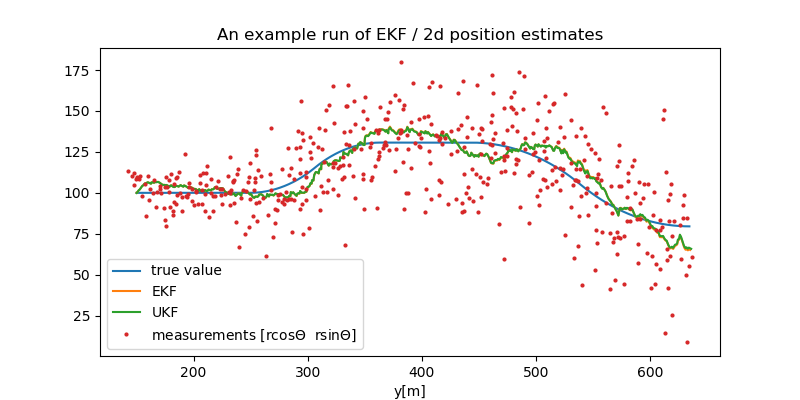

In [5]:
# This is an example run of EKF
# Generate random measurement sequence
y = np.zeros((ny,Tfinal))
y = GenerateRandMeas()

# Run EKF using above generated measurements
xu     = UKF(y)
xe, yx = EKF(y)


%matplotlib notebook
fig= plt.figure(figsize=(8,4))
plt.plot(true_traj[0,:],true_traj[1,:]);
plt.plot(xe[0,0:Tfinal],xe[1,0:Tfinal]);
plt.plot(xu[0,0:Tfinal],xu[1,0:Tfinal]);
plt.plot(yx[0,:],yx[1,:],'o',markersize=2);
plt.xlabel('x[m]');
plt.xlabel('y[m]');
plt.title('An example run of EKF / 2d position estimates');
plt.legend(['true value','EKF','UKF','measurements [rcos$\Theta$  rsin$\Theta$]']);

